In [155]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
#plt.ioff()

results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_frac.pkl", "rb"))
#results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_count_NOT_known_particles1.pkl", "rb"))
#fname = "/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/temporary_22082023_with_reco_count_known_particles1.pkl"
fname = "/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23_08_larger_DS_known_particle_ckpts/temp_ckpt.pkl"
results = pickle.load(open(fname, "rb"))
#results = pickle.load(open("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23_08_larger_DS_known_particle_ckpts/temp_ckpt.pkl", "rb"))
result = results


In [156]:
#results =results[0.4]
#result = results[0.4]
#result=results


In [157]:
print(result["total_counts"])
print(sum(result["total_counts"].values()))

{2112: 10323.0, -211: 5247.0, 2212: 4760.0, -2212: 5121.0, 130: 12188.0, 211: 5185.0}
42824.0


In [158]:
def divide_dicts(num, denom):
    d = {}
    for k in num.keys():
        if denom[k] == 0 or k not in denom:
            d[k] = "inf"
        else:
            d[k] = num[k] / denom[k]
    return d
res = divide_dicts(result["reco_counts"], result["total_counts"])
print("Efficiency per particle type:", res)

Efficiency per particle type: {2112: 1.0, -211: 1.0, 2212: 1.0, -2212: 1.0, 130: 1.0, 211: 1.0}


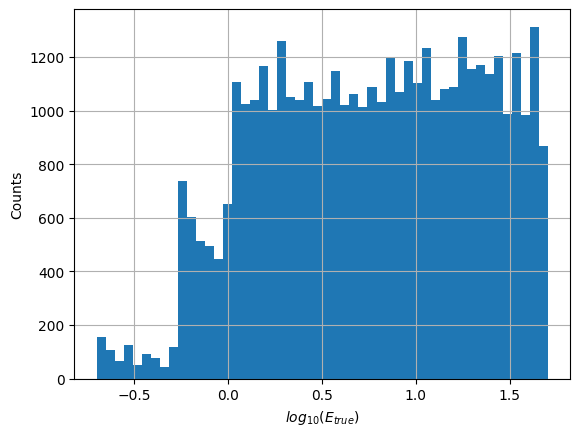

In [159]:
fig, ax = plt.subplots()
ax.hist(np.log10(result["part_E_true"]), bins=50,label="Energy true")
ax.set_xlabel("$log_{10} (E_{true})$")
ax.set_ylabel("Counts")
ax.grid()
fig.show()

In [160]:
result["part_E_true"].max().item(), result["part_E_true"].min().item()

(50.425819396972656, 0.20034070312976837)

In [161]:
ranges = [(0.2, 1), (1, 10), (10, 50)]

In [162]:
e_frac_per_pid_and_range = {}
for pid in result["part_PID_true"].unique():
    e_frac_per_pid_and_range[pid] = {}
    for r in ranges:
        e_frac_per_pid_and_range[pid][r] = []
        idx = [i for i, x in enumerate(result["part_PID_true"]) if x == pid and result["part_E_true"][i] > r[0] and result["part_E_true"][i] <= r[1]]
        e_frac_per_pid_and_range[pid][r] = result["loss_e_fracs"][idx]
num_pids, num_ranges = len(e_frac_per_pid_and_range.keys()), len(ranges)

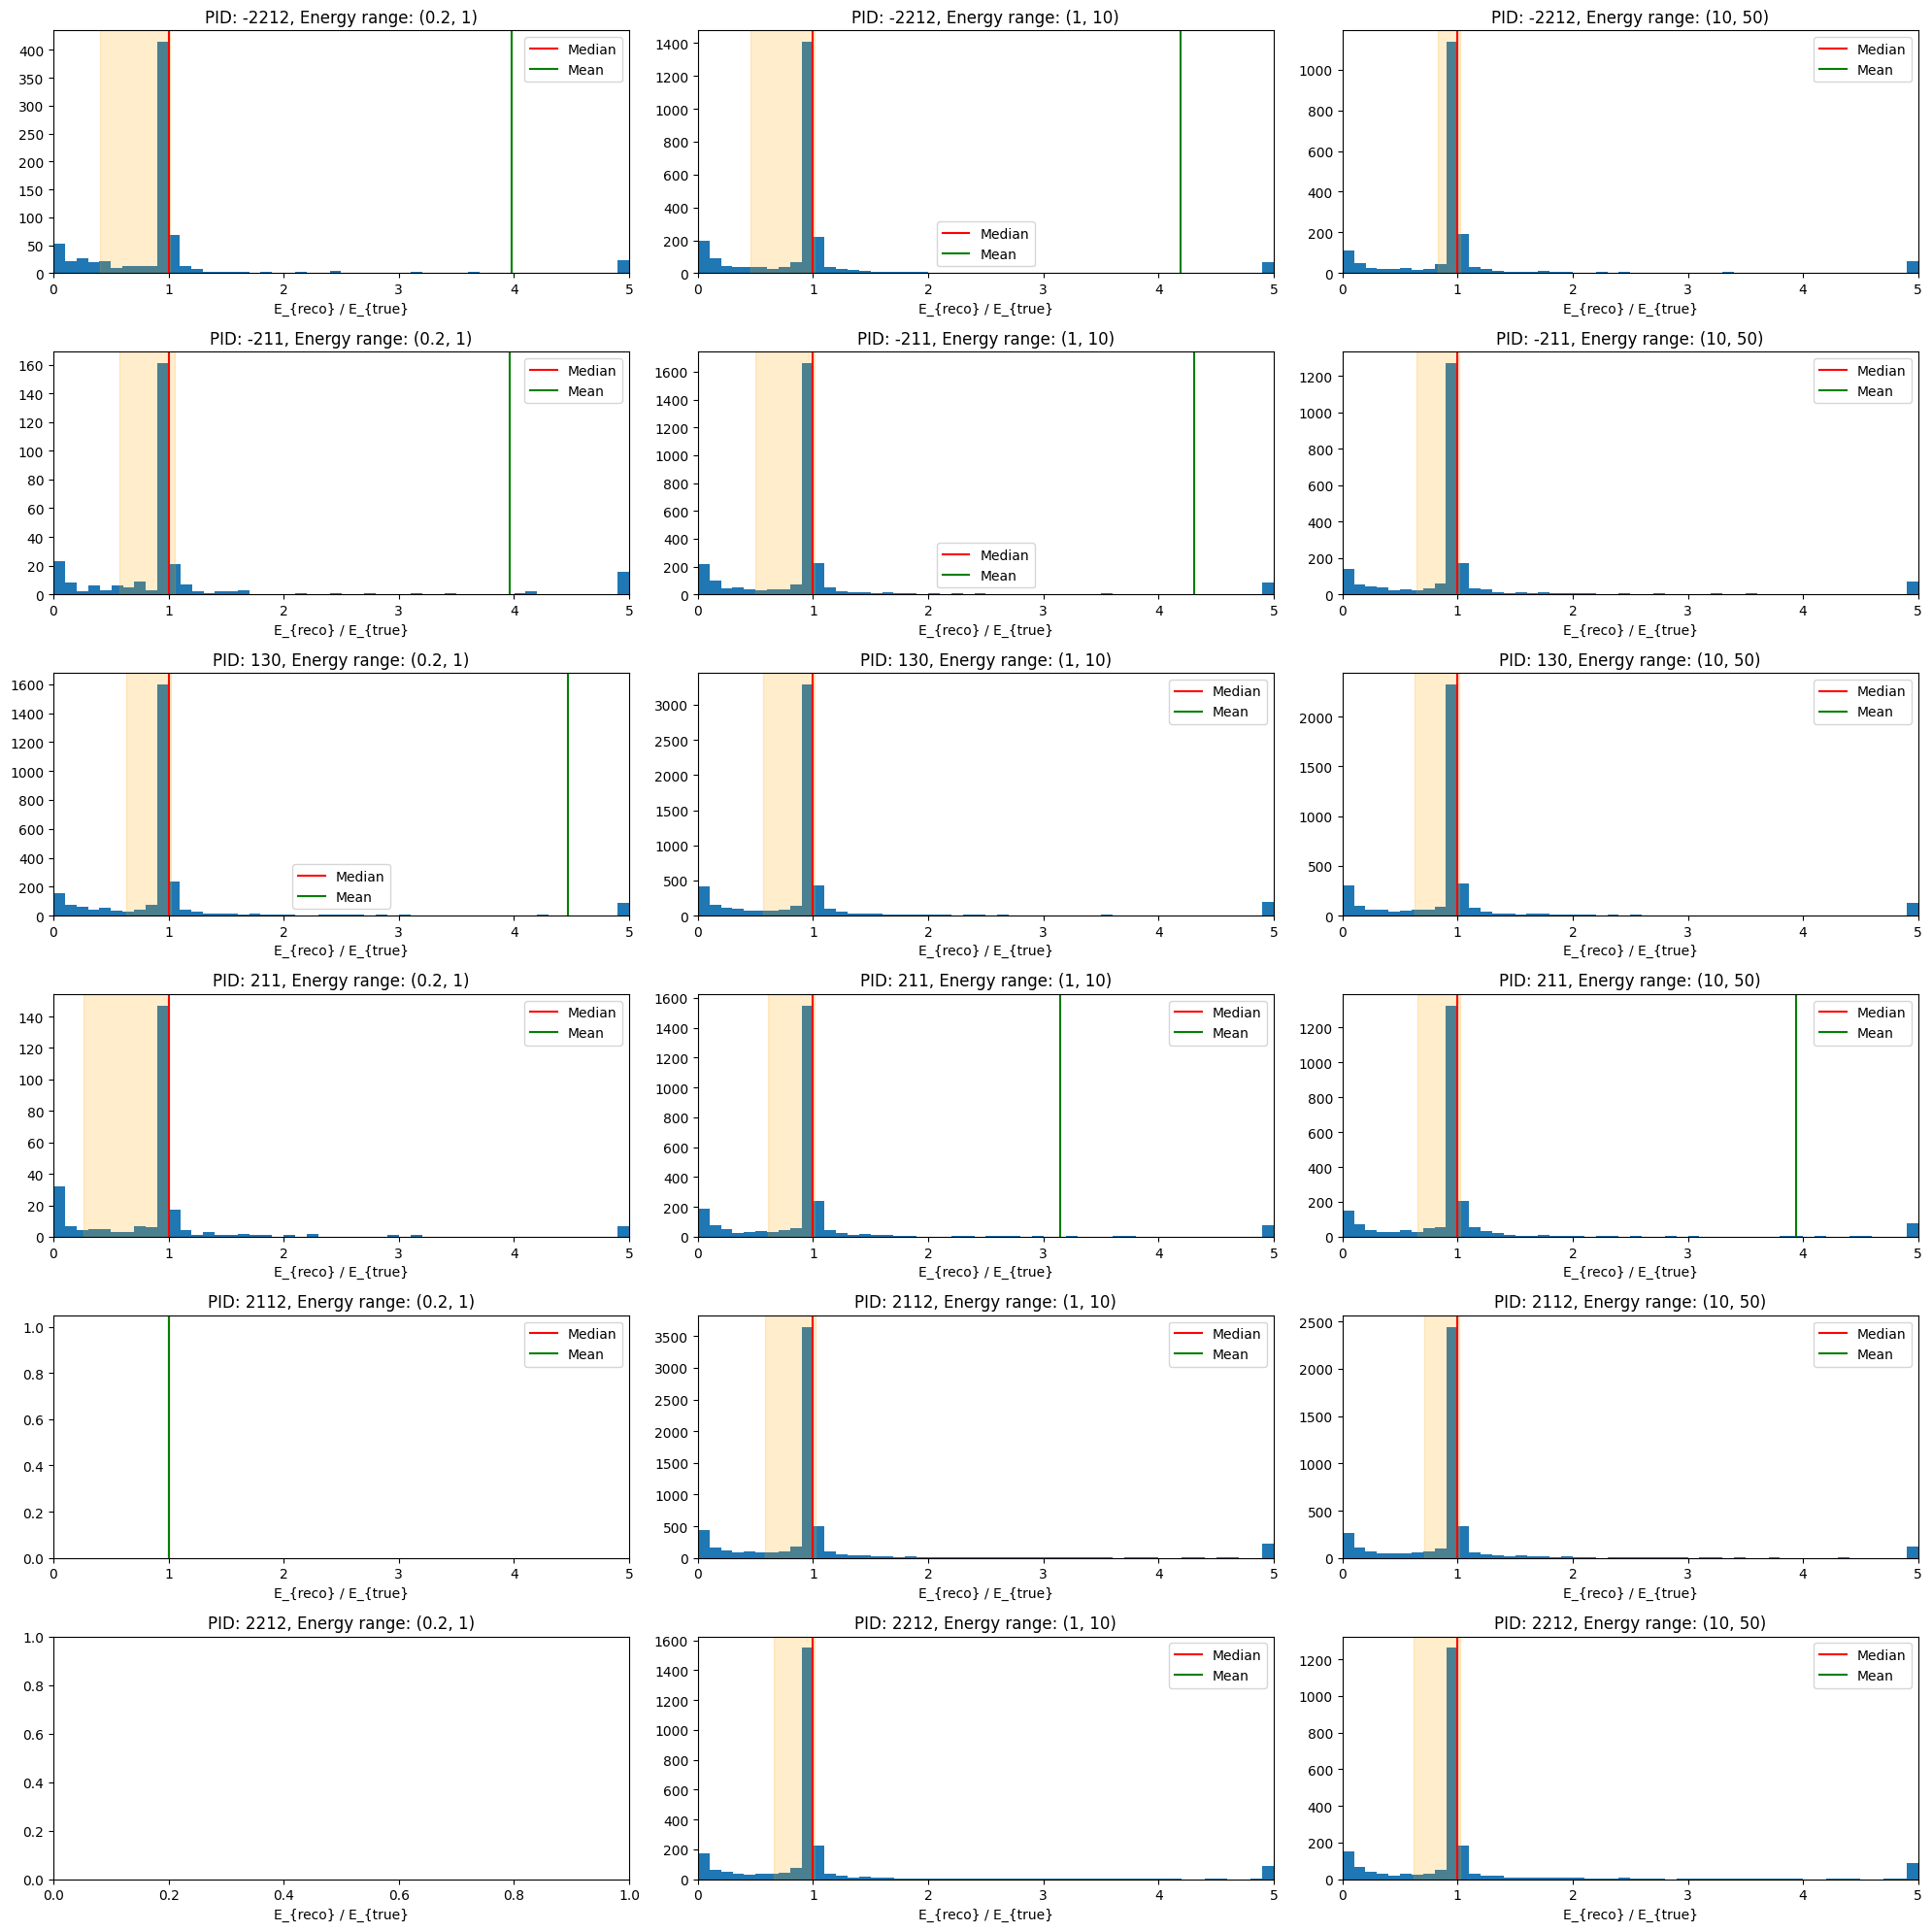

In [163]:
fig, ax = plt.subplots(num_pids, num_ranges, figsize=(20, 20))
intervals = {}
def clip(data, n):
    return [x if x < n else n for x in data]

for i, pid in enumerate(e_frac_per_pid_and_range.keys()):
    for j, r in enumerate(ranges):
        data = e_frac_per_pid_and_range[pid][r]
        if len(data):
            median, mean = data.median(), data.mean()
            interval_68 = (np.percentile(data, 16), np.percentile(data, 84))
            data = clip(data, 5)
            ax[i, j].hist(data, bins=50, label="")
            ax[i, j].set_xlim([0, 5])
            ax[i, j].axvline(median, color="red", label="Median")
            ax[i, j].axvline(mean, color="green", label="Mean")
            #ax[i, j].axvline(interval_68[0], color="orange", label="68% interval")
            #ax[i, j].axvline(interval_68[1], color="orange")
            # shaded 68% interval
            ax[i, j].axvspan(interval_68[0], interval_68[1], 0, 5, color="orange", alpha=0.2)
            intervals[(pid, r)] = interval_68
            ax[i, j].legend()
        ax[i, j].set_xlabel("E_{reco} / E_{true}")
        ax[i, j].set_title(f"PID: {pid}, Energy range: {r}")


fig.tight_layout()
fig.show()
#fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23082023_plots/plot_with_known_particle_match_NOT_known_part.pdf")

In [91]:
result["part_PID_true"]

tensor([2212, 2212, 2212,  ..., -211, -211, -211])

In [ ]:
fig, ax = plt.subplots(num_pids, 1, figsize=(5, 10))
for i, pid in enumerate(e_frac_per_pid_and_range.keys()):
    sigmas, energies = [], []
    #sigmas = [intervals[(pid, r)] for r in ranges]
    #energies = [r[1] for r in ranges]
    for j in range(len(ranges)):
        if (pid, ranges[j]) in intervals:
            sigmas.append((intervals[(pid, ranges[j])][1] - intervals[(pid, ranges[j])][0]) / 2)
            energies.append(ranges[j][1])
    ax[i].plot(energies, sigmas, ".-")
    ax[i].set_xlabel("E")
    ax[i].set_ylabel("$\sigma_E/E$")
    ax[i].set_title(f"PID: {pid} (N={sum(result['part_PID_true'] == pid)})")
    #ax[i].set_xscale("log")
    ax[i].grid()
    ax[i].set_xlim([0, 0.5])
fig.tight_layout()
fig.show()
#fig.savefig("/eos/user/g/gkrzmanc/summ_results/frac_energy_plots/23082023_plots/sigma_vs_energy_with_known_particle_match_range.pdf")


In [130]:
intervals

{(tensor(-2212), (1, 10)): (0.12034607172012331, 4.91493034362793),
 (tensor(-2212), (10, 50)): (0.016429197043180466, 2.934537172317505),
 (tensor(-211), (1, 10)): (0.40995076298713684, 11.548728942871094),
 (tensor(-211), (10, 50)): (0.005377148911356926, 3.0041754245758057),
 (tensor(130), (0.2, 1)): (0.03408333659172058, 6.059825401306143),
 (tensor(130), (1, 10)): (0.20565769970417025, 5.347243309020996),
 (tensor(130), (10, 50)): (0.09016579777002334, 2.0085119152069035),
 (tensor(211), (1, 10)): (0.2910022819042205, 9.457018852233887),
 (tensor(211), (10, 50)): (0.2586120921373368, 6.554231643676758),
 (tensor(2112), (1, 10)): (0.04616831615567207, 5.163581848144531),
 (tensor(2112), (10, 50)): (0.24925027787685394, 2.937476634979248),
 (tensor(2212), (1, 10)): (0.32945799708366397, 8.981017112731934),
 (tensor(2212), (10, 50)): (0.023017104789614693, 2.7508585453033447)}